SIADS 593 - Milestone 1 Project Notebook

# Merging Datasets

In order to conduct analysis, we must first integrate socioeconomic and demographic indicators with the dengue case data. This involves leveraging pandas to load both datasets, and re-orienting the data through melting to maintain a consistent format across both files. and then merging the two files into one dataframe.

Note: The original website containing the data for file2_path is no longer available in the format originally accessed. We have found a page from the same source (Pan American Health Organizations) that includes the same data just in a different format. If the data is downloaded from the link in the SlideDoc, it will not work with this code. Please use the provided CSV file.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load in csv data files
file2_path = "/W_Tabla_Full_Data_data-2.csv"
file1_path = "/8748eeb3-b878-4372-bcf6-28eb30775315_Data.csv"
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Match country names between datasets
country_mapping = {
    'Venezuela, RB': 'Venezuela',
    'United States': 'United States of America'
}
df1['Country Name'] = df1['Country Name'].replace(country_mapping)

indicator_names = [
    "GNI per capita, Atlas method (current US$)",
    "Population density (people per sq. km of land area)",
    "Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)",
    "Population, total"
]

# Clean World Bank dataset and melt
df1_filtered = df1[df1["Series Name"].isin(indicator_names)]
df1_melted = df1_filtered.melt(
    id_vars=["Country Name", "Series Name"],
    value_vars=[col for col in df1.columns if "[YR" in col],
    var_name="Year",
    value_name="Value"
)
df1_melted["Year"] = df1_melted["Year"].str.extract(r"(\d{4})").astype(int)
df1_pivot = df1_melted.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Name",
    values="Value",
    aggfunc="first"
).reset_index()

# Clean Dengue dataset
df2_cleaned = df2.copy()
df2_cleaned.columns = df2_cleaned.columns.str.strip()
df2_cleaned = df2_cleaned.rename(columns={
    "Non Severe Dengue": "Non-Severe Dengue Cases",
    "Severe Dengue": "Severe Dengue Cases",
    "Total Dengue Cases": "Total Dengue Cases"
})

# Merge datasets together
merged_df = pd.merge(
    df2_cleaned,
    df1_pivot,
    left_on=["Country", "Year"],
    right_on=["Country Name", "Year"],
    how="left"
)

# Drop unnecessary columns
merged_df.drop(columns=["Country Name", "MaxEW"], inplace=True)

print(merged_df.columns)

Index(['Country', 'Year', 'Deaths', 'Non-Severe Dengue Cases',
       'Severe Dengue Cases', 'Total Dengue Cases',
       'GNI per capita, Atlas method (current US$)',
       'Population density (people per sq. km of land area)',
       'Population, total',
       'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)'],
      dtype='object')


In [ ]:
# Sample of merged dataset
merged_df.head(10)

,Country,Year,Deaths,Non-Severe Dengue Cases,Severe Dengue Cases,Total Dengue Cases,"GNI per capita, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)
0,Argentina,2013,0,"9,294",0,"9,294",12760,15.5598387102668,42582455,0.7
1,Chile,2013,0,44,0,44,15080,23.7878208335351,17687006,0.5
2,United States of America,2014,0,668,0,668,55670,34.8061342979769,318386329,1.2
3,Uruguay,2014,0,0,0,0,17140,19.1768597874529,3356334,0.2
4,Venezuela,2014,0,"87,308",221,"87,529",12990,34.2997324414716,30254079,..
5,Brazil,2018,160,"462,003",323,"462,326",9320,24.659465024515,206107261,5.3
6,Colombia,2018,23,"44,299",526,"44,825",6350,44.1860883280757,49024465,4.5
7,Canada,2015,0,0,0,0,47580,3.98239245827659,35704498,0.2
8,Chile,2015,0,40,0,40,14080,24.2728288762286,18047625,0.4
9,Guyana,2015,0,388,0,388,5530,3.85461518923038,758781,..


# Cleaning Data

The data has a set of cleanliness challenges. These primarily revolve around the use of not applicable values and specifically the different ways they are represented. A further matter is that the the columns are being recognized as objects as opposed to numbers. These are resolved by changing all forms of missing data to NaN, converting the columns to numeric values, and filling in missing data with the mean of that feature of that country over all years in the data.

In [ ]:
# Clean values and replace missing ones with NaN
for col in merged_df.columns:
    if col not in ['Year', 'Country']:
        merged_df[col] = (
        merged_df[col]
        .astype(str)
        .str.replace(',', '', regex=False)
        .replace({'..': np.nan, '': np.nan, 'nan': np.nan, '<NA>': np.nan})
    )

# Convert values to numeric
cols_to_convert = [col for col in merged_df.columns if col not in ['Year', 'Country']]
for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Fill NaN with mean of each country for each variable across all years
cols_to_fill = [
    col for col in merged_df.select_dtypes(include='number').columns
    if col not in ['Year']
]
for col in cols_to_fill:
    merged_df[col] = merged_df.groupby('Country')[col].transform(lambda x: x.fillna(x.mean()))

# Countries missing all values in a column will be dropped (Venezuela, Guyana)
merged_data_filled = merged_df.dropna()

merged_data_filled.sample(10)

,Country,Year,Deaths,Non-Severe Dengue Cases,Severe Dengue Cases,Total Dengue Cases,"GNI per capita, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)
107,Canada,2021,0,0,0.0,0,48780.0,4.351026,38239864,0.242857
35,Argentina,2016,10,79425,30.0,79455,12130.0,16.041391,43900313,0.700000
83,Bolivia,2015,1,27013,86.0,27099,2920.0,10.167733,11014705,4.600000
88,Ecuador,2016,4,14120,39.0,14159,5750.0,66.456511,16505139,3.600000
11,Paraguay,2015,5,68639,13.0,68652,6100.0,15.502399,6159103,1.900000
91,Peru,2023,441,273172,1055.0,274227,7090.0,24.718692,33845617,4.190000
80,Argentina,2020,19,59271,87.0,59358,9040.0,16.513367,45191965,1.200000
38,Chile,2016,0,33,0.0,33,13310.0,24.568171,18267221,0.600000
72,Suriname,2018,0,123,0.0,123,5730.0,3.735106,599513,1.100000
157,Ecuador,2022,13,15908,109.0,16017,6590.0,71.766375,17823897,3.200000


#Analysis

In [ ]:
# Create column lists for later analysis
numeric_columns = [
    'GNI, PPP (current international $)',
    'Population density (people per sq. km of land area)',
    'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
    'Non-Severe Dengue Cases',
    'Severe Dengue Cases',
    'Total Dengue Cases',
    'Deaths',
    'Population, total'
]

economic_columns = [
    'GNI, PPP (current international $)',
    'Population density (people per sq. km of land area)',
    'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
    'Population, total'
]

dengue_columns = [
    'Non-Severe Dengue Cases',
    'Severe Dengue Cases',
    'Total Dengue Cases',
    'Deaths'
]

##Foundational Statistics

The intital analysis will begin with an overview of the dengue case related columns.

In [ ]:
print(f"Countries: {merged_data_filled['Country'].nunique()}")
print(f"Years: {merged_data_filled['Year'].min()}-{merged_data_filled['Year'].max()}")
print(f"Total observations: {len(merged_data_filled)}")
print(f"Total dengue cases: {merged_data_filled['Total Dengue Cases'].sum():,.0f}")
print(f"Total deaths: {merged_data_filled['Deaths'].sum():,.0f}")
print(f"Overall case fatality rate: {(merged_data_filled['Deaths'].sum() / merged_data_filled['Total Dengue Cases'].sum() * 100):.3f}%")
print(f"Overall non-severe case rate: {(merged_data_filled['Non-Severe Dengue Cases'].sum() / merged_data_filled['Total Dengue Cases'].sum() * 100):.1f}%")

Countries: 13
Years: 2013-2023
Total observations: 143
Total dengue cases: 21,868,710
Total deaths: 10,365
Overall case fatality rate: 0.047%
Overall non-severe case rate: 99.6%


In [ ]:
# Create dataframe with total dengue cases per country across all years
country_totals = merged_data_filled.groupby('Country').agg({
    'Total Dengue Cases': 'sum',
    'Deaths': 'sum',
    'Non-Severe Dengue Cases': 'sum',
    'Severe Dengue Cases': 'sum'
}).sort_values('Total Dengue Cases', ascending=False)

country_totals

,Total Dengue Cases,Deaths,Non-Severe Dengue Cases,Severe Dengue Cases
Country,,,,
Brazil,17021195,6641,17004637,16558.000
Mexico,1638337,1181,1596518,41819.000
Colombia,963116,820,947872,15244.000
Peru,653431,909,650992,2439.000
Paraguay,650676,404,648341,3210.625
Bolivia,432558,190,430227,2331.000
Argentina,313446,104,313042,404.000
Ecuador,187554,113,186919,635.000
United States of America,6821,0,6755,66.000


In [ ]:
# Dengue case and severity summary across all countries each year
yearly_summary = merged_data_filled.groupby('Year').agg({
    'Total Dengue Cases': 'sum',
    'Deaths': 'sum',
    'Non-Severe Dengue Cases': 'sum',
    'Severe Dengue Cases': 'sum'
}).round(0)

yearly_summary

,Total Dengue Cases,Deaths,Non-Severe Dengue Cases,Severe Dengue Cases
Year,,,,
2013,2024423,1183,1993279,31144.0
2014,896048,585,883525,12523.0
2015,2144893,1115,2136152,8741.0
2016,2680698,870,2677760,2938.0
2017,720672,275,719434,1238.0
2018,638031,265,636184,2139.0
2019,2706431,1426,2699645,7078.0
2020,2134931,917,2131025,3906.0
2021,1165408,385,1163535,2165.0


##Economic Analysis

We will now classify each country by their income level and complete the anlysis on the socioeconomic columns.

In [ ]:
# World Bank income classification system
def classify_income_world_bank(gni_per_capita):
    if pd.isna(gni_per_capita):
        return 'Unknown'
    elif gni_per_capita < 1135:
        return 'Low'
    elif gni_per_capita < 4465:
        return 'Lower middle'
    elif gni_per_capita < 13845:
        return 'Upper middle'
    else:
        return 'High'

# Apply classification on merged data
gni_column = 'GNI per capita, Atlas method (current US$)'
merged_data_filled = merged_data_filled.copy()
merged_data_filled.loc[:, 'Income_Level'] = merged_data_filled[gni_column].apply(classify_income_world_bank)

In [ ]:
# Observation per income level (out of 143 total observations)
income_breakdown = merged_data_filled['Income_Level'].value_counts()
income_breakdown

,count
Income_Level,
Upper middle,90
High,41
Lower middle,12


In [ ]:
# Dengue cases by income level
dengue_by_income = merged_data_filled.groupby('Income_Level')[['Non-Severe Dengue Cases', 'Severe Dengue Cases','Total Dengue Cases', 'Deaths'
                      ]].agg(['sum', 'mean', 'median'
]).round(2)

dengue_by_income

Non-Severe Dengue Cases                     Severe Dengue Cases  \
                                 sum       mean   median                 sum   
Income_Level                                                                   
High                            7132     173.95     13.0               66.00   
Lower middle                  430790   35899.17  19914.5             2331.00   
Upper middle                21348954  237210.60  39429.5            80312.62   

                            Total Dengue Cases                     Deaths  \
                mean median                sum       mean   median    sum   
Income_Level                                                                
High            1.61    0.0               7198     175.56     13.0      0   
Lower middle  194.25   64.5             433121   36093.42  19997.0    190   
Upper middle  892.36  123.5           21428391  238093.23  39607.5  10175   

                             
                mean median  
Income_Level                 
High            0.00    0.0  
Lower middle   15.83    4.0  
Upper middle  113.06   23.5

In [ ]:
# Dengue case rates by income level per 100,000 people

# Incidence_Rate will be used later for correlation analysis
merged_data_filled.loc[:, 'Incidence_Rate'] = (merged_data_filled['Total Dengue Cases'] /
                                        merged_data_filled['Population, total'] * 100000)

incidence_by_income = merged_data_filled.groupby('Income_Level')['Incidence_Rate'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

incidence_by_income

,count,mean,median,std,min,max
Income_Level,,,,,,
High,41,0.23,0.05,0.47,0.00,2.36
Lower middle,12,314.19,168.45,390.02,66.01,1296.49
Upper middle,90,284.92,108.13,512.75,0.05,3388.72


In [ ]:
# Mortality analysis by income level
merged_data_filled.loc[:, 'Death_Rate_per_100k'] = (merged_data_filled['Deaths'] /
                                             merged_data_filled['Population, total'] * 100000)

death_analysis = merged_data_filled.groupby('Income_Level').agg({
    'Death_Rate_per_100k': ['mean', 'max'],
    'Deaths': ['sum', 'mean'],
    'Total Dengue Cases': 'sum'
}).round(3)

death_analysis

Death_Rate_per_100k        Deaths          Total Dengue Cases
                            mean    max    sum     mean                sum
Income_Level                                                              
High                       0.000  0.000      0    0.000               7198
Lower middle               0.133  0.719    190   15.833             433121
Upper middle               0.184  4.196  10175  113.056           21428391

In [ ]:
# Dengue severity by income level
merged_data_filled.loc[:, 'Severity_Ratio'] = (merged_data_filled['Severe Dengue Cases'] /
                                        merged_data_filled['Total Dengue Cases'] * 100)

severity_analysis = merged_data_filled.groupby('Income_Level').agg({
    'Severity_Ratio': ['mean', 'median', 'std'],
    'Severe Dengue Cases': ['mean', 'sum']
}).round(2)

severity_analysis

Severity_Ratio              Severe Dengue Cases          
                       mean median   std                mean       sum
Income_Level                                                          
High                   0.44   0.00  0.72                1.61     66.00
Lower middle           0.52   0.47  0.41              194.25   2331.00
Upper middle           0.68   0.32  1.22              892.36  80312.62

##Correlation Analysis

In order to analyze the relationships between different columns we will create a correlation matrix.

In [ ]:
# Correlation matrix for key relationships
correlation_columns = [
    'GNI per capita, Atlas method (current US$)',
    'Population density (people per sq. km of land area)',
    'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
    'Total Dengue Cases',
    'Deaths',
    'Severe Dengue Cases',
    'Incidence_Rate'
]

correlation_matrix = merged_data_filled[correlation_columns].corr().round(3)
correlation_matrix

,"GNI per capita, Atlas method (current US$)",Population density (people per sq. km of land area),Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Total Dengue Cases,Deaths,Severe Dengue Cases,Incidence_Rate
"GNI per capita, Atlas method (current US$)",1.000,-0.104,-0.449,-0.129,-0.154,-0.112,-0.239
Population density (people per sq. km of land area),-0.104,1.000,0.377,0.012,0.057,0.294,-0.076
Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),-0.449,0.377,1.000,0.291,0.320,0.197,0.197
Total Dengue Cases,-0.129,0.012,0.291,1.000,0.957,0.214,0.490
Deaths,-0.154,0.057,0.320,0.957,1.000,0.275,0.515
Severe Dengue Cases,-0.112,0.294,0.197,0.214,0.275,1.000,0.136
Incidence_Rate,-0.239,-0.076,0.197,0.490,0.515,0.136,1.000


##Further Analysis

Some further analysis includes looking at yearly trends and comparing country level data that was generated in previous cells (Incidence_Rate, Income_Level).

In [ ]:
# Yearly economic and dengue trends
yearly_trends = merged_data_filled.groupby('Year').agg({
    'Total Dengue Cases': 'sum',
    'Deaths': 'sum',
    'GNI per capita, Atlas method (current US$)': 'mean',
    'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)': 'mean',
    'Incidence_Rate': 'mean'
}).round(2)

yearly_trends

,Total Dengue Cases,Deaths,"GNI per capita, Atlas method (current US$)",Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Incidence_Rate
Year,,,,,
2013,2024423,1183,16313.08,2.44,299.61
2014,896048,585,16473.08,2.36,91.15
2015,2144893,1115,15842.31,2.27,227.56
2016,2680698,870,15051.54,2.39,245.95
2017,720672,275,15056.92,2.24,61.62
2018,638031,265,15840.77,2.10,77.91
2019,2706431,1426,16255.38,2.05,156.05
2020,2134931,917,14935.38,2.61,444.16
2021,1165408,385,16289.23,2.13,92.56


In [ ]:
# A look into incidence rate with correlated factors
country_performance = merged_data_filled.groupby('Country').agg({
    'Incidence_Rate': 'mean',
    'Income_Level': 'first',
    'GNI per capita, Atlas method (current US$)': 'mean',
    'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)': 'mean',
    'Total Dengue Cases': 'sum',
    'Deaths': 'sum'
}).sort_values('Incidence_Rate', ascending=False).round(2)

country_performance

,Incidence_Rate,Income_Level,"GNI per capita, Atlas method (current US$)",Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population),Total Dengue Cases,Deaths
Country,,,,,,
Paraguay,927.89,Upper middle,5954.55,1.40,650676,404
Brazil,749.74,Upper middle,9640.00,4.29,17021195,6641
Bolivia,334.40,Lower middle,3158.18,3.88,432558,190
Peru,181.45,Upper middle,6498.18,4.19,653431,909
Colombia,179.09,Upper middle,6803.64,5.81,963116,820
Mexico,120.17,Upper middle,10197.27,2.30,1638337,1181
Ecuador,100.61,Upper middle,6059.09,3.64,187554,113
Argentina,63.49,Upper middle,11829.09,0.82,313446,104
Suriname,17.03,Upper middle,6300.00,1.10,1147,3


# Visualizations


The visualizations created correlate with the previous analysis done.

## Dengue Case Severity Visuals

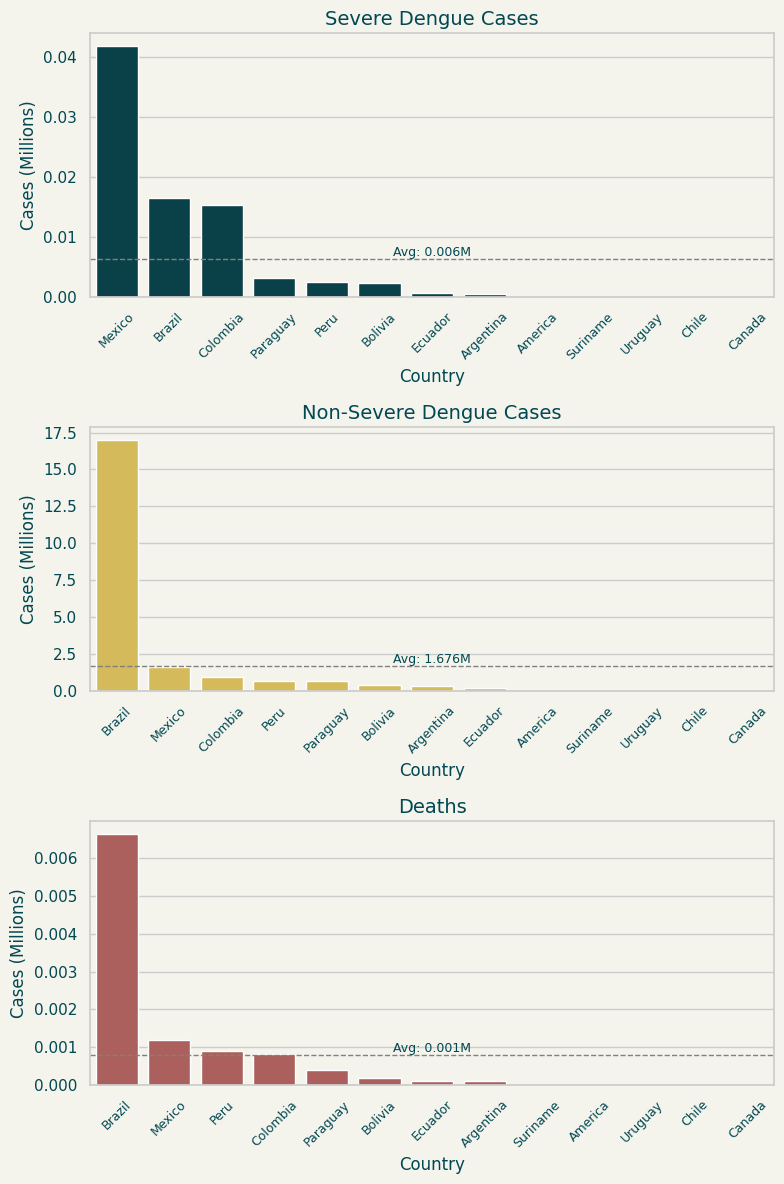

In [ ]:
# Create three separate bar charts showcasing the number of cases in each country

def bar_dengue_severity(df):

    # Rename United States of America as it takes up space on x-axis
    df = df.rename(index={'United States of America': 'America'})

    # Define dengue case types as well as their corresponding colors
    case_types = ['Severe Dengue Cases', 'Non-Severe Dengue Cases', 'Deaths']
    colors = ['#004852ff', '#e8c547ff', '#b85450ff']
    text_color = '#004852ff'
    background_color = '#f4f3ecff'

    # Use seaborn and create subplots
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
    fig.patch.set_facecolor(background_color)

    for ax, case_type, color in zip(axes, case_types, colors):
        data = df.sort_values(case_type, ascending=False)
        sns.barplot(x=data.index, y=data[case_type] / 1_000_000, color=color, ax=ax)

      # Add a horizontal line showing the average
        avg_val = (df[case_type] / 1_000_000).mean()
        ax.axhline(avg_val, color='gray', linestyle='--', linewidth=1)
        ax.text(0.5, avg_val, f'Avg: {avg_val:.3f}M', color=text_color, fontsize=9,
                ha='center', va='bottom', transform=ax.get_yaxis_transform())

        ax.set_facecolor(background_color)
        ax.set_title(case_type, color=text_color, fontsize=14)
        ax.set_ylabel('Cases (Millions)', color=text_color)
        ax.set_xlabel('Country', color=text_color)
        ax.tick_params(axis='x', rotation=45, labelsize=9, colors=text_color)
        ax.tick_params(axis='y', colors=text_color)

    plt.tight_layout()
    plt.show()

bar_dengue_severity(country_totals)

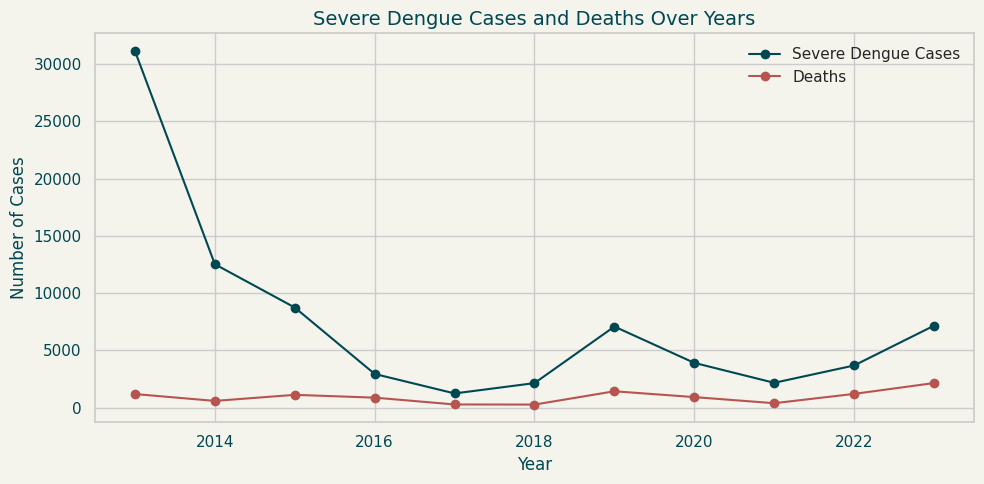

In [ ]:
# Create a line chart of comparing severe dengue cases and death over time

def line_dengue_severity(df):

    # Define dengue case types as well as their corresponding colors
    case_types = ['Severe Dengue Cases', 'Deaths']
    colors = ['#004852ff', '#b85450ff']
    text_color = '#004852ff'
    background_color = '#f4f3ecff'

    sns.set(style='whitegrid')

    # Plot line chart based on each case type
    plt.figure(figsize=(10, 5))
    plt.gcf().set_facecolor(background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)

    for case_type, color in zip(case_types, colors):
        plt.plot(df.index, df[case_type], marker='o', color=color, label=case_type)

    plt.title('Severe Dengue Cases and Deaths Over Years', color=text_color, fontsize=14)
    plt.xlabel('Year', color=text_color)
    plt.ylabel('Number of Cases', color=text_color)

    plt.tick_params(axis='x', colors=text_color)
    plt.tick_params(axis='y', colors=text_color)
    plt.legend(frameon=False, loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

line_dengue_severity(yearly_summary)

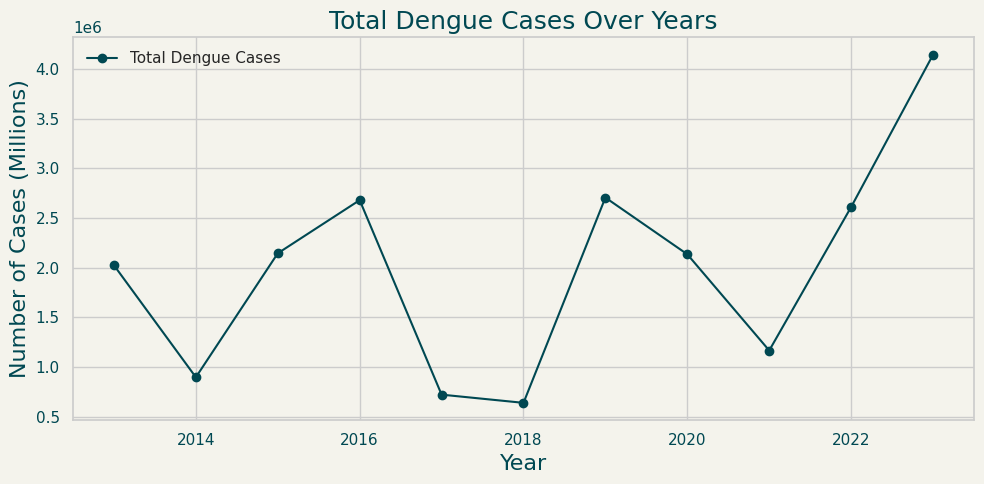

In [ ]:
# Create a line chart of comparing total dengue cases over time

def line_total_dengue(df):

    case_type = 'Total Dengue Cases'
    color = '#004852ff'
    text_color = '#004852ff'
    background_color = '#f4f3ecff'

    # Set seaborn style
    sns.set(style='whitegrid')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.gcf().set_facecolor(background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)

    plt.plot(df.index, df[case_type], marker='o', color=color, label=case_type)

    plt.title('Total Dengue Cases Over Years', color=text_color, fontsize=18)
    plt.xlabel('Year', color=text_color, fontsize = 16)
    plt.ylabel('Number of Cases (Millions)', color=text_color, fontsize=16)

    plt.tick_params(axis='x', colors=text_color)
    plt.tick_params(axis='y', colors=text_color)
    plt.legend(frameon=False, loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

line_total_dengue(yearly_summary)

## Economic Visuals

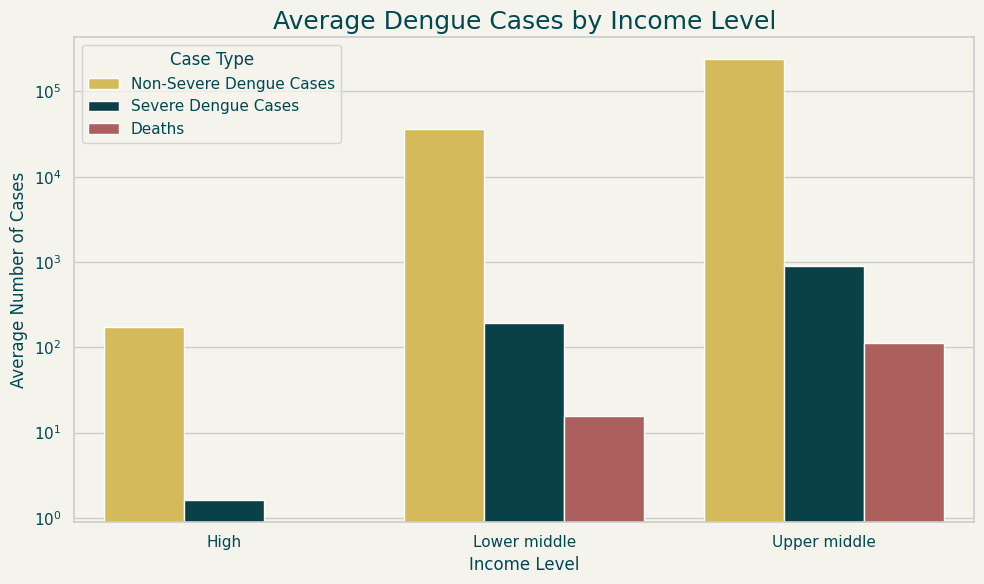

In [ ]:
# Create a grouped bar chart of average cases per income level

def grouped_bar_dengue(df):

    # Extract mean values by income level and relevant columns
    dengue_mean_df = df.xs('mean', axis=1, level=1)
    dengue_mean_df = dengue_mean_df[['Non-Severe Dengue Cases', 'Severe Dengue Cases', 'Deaths']]
    dengue_mean_df = dengue_mean_df.reset_index()  # Move Income_Level from index to column

    # Melt DataFrame for grouped bar chart
    melted_df = pd.melt(
        dengue_mean_df,
        id_vars='Income_Level',
        value_vars=['Non-Severe Dengue Cases', 'Severe Dengue Cases', 'Deaths'],
        var_name='Case Type',
        value_name='Average Cases'
    )

    # Plot figure
    background_color = '#f4f3ecff'
    text_color = '#004852ff'
    palette = ['#e8c547ff', '#004852ff', '#b85450ff']

    plt.figure(figsize=(10, 6))
    plt.gcf().set_facecolor(background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)
    sns.set(style='whitegrid')

    # Create grouped bar plot using seaborn
    sns.barplot(
        data=melted_df,
        x='Income_Level',
        y='Average Cases',
        hue='Case Type',
        palette=palette
    )

    # Use log y-axis due to disproportionate values
    plt.yscale('log')

    plt.title('Average Dengue Cases by Income Level', color=text_color, fontsize=18)
    plt.xlabel('Income Level', color=text_color)
    plt.ylabel('Average Number of Cases', color=text_color)
    plt.tick_params(axis='x', colors=text_color)
    plt.tick_params(axis='y', colors=text_color)

    # Add in legend
    legend = plt.legend(title='Case Type', facecolor=background_color)
    for text in legend.get_texts():
        text.set_color(text_color)
    legend.get_title().set_color(text_color)

    plt.tight_layout()
    plt.show()


grouped_bar_dengue(dengue_by_income)

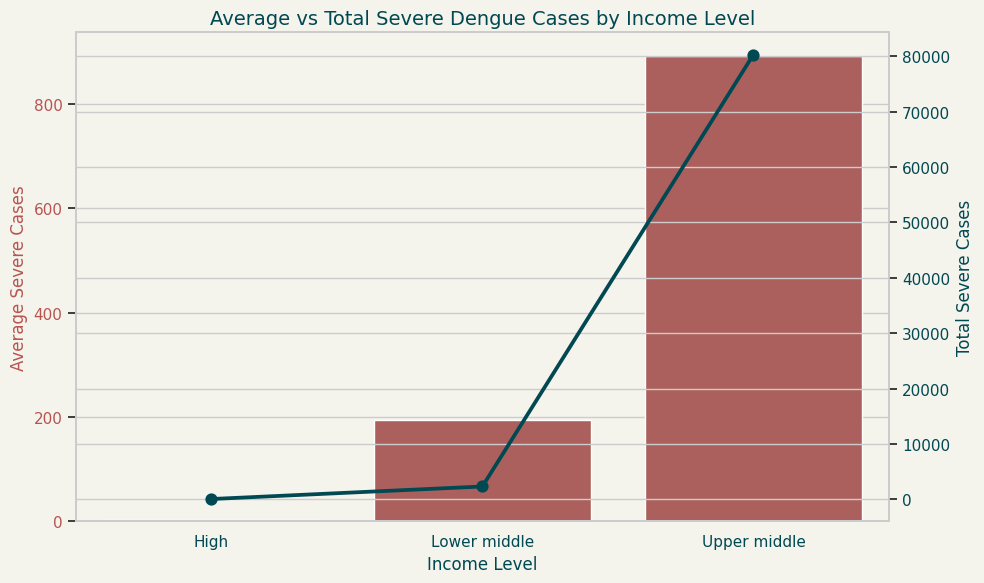

In [ ]:
# Create a bar and line chart

def severity_chart(df):

    df = df.copy()
    df.columns = ['_'.join(col).strip() for col in df.columns.values]  # Flatten multi-level columns
    df = df.reset_index()  # Ensure Income_Level is a column

    # Add in color coding
    background_color = '#f4f3ecff'
    bar_color = '#b85450ff'
    line_color = '#004852ff'
    text_color = '#004852ff'

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor(background_color)
    ax1.set_facecolor(background_color)

    # Bar plot: Mean severe cases
    sns.barplot(
        data=df,
        x='Income_Level',
        y='Severe Dengue Cases_mean',
        color=bar_color,
        ax=ax1
    )
    ax1.set_ylabel('Average Severe Cases', color=bar_color)
    ax1.set_xlabel('Income Level', color=text_color)
    ax1.tick_params(axis='x', labelcolor=text_color)
    ax1.tick_params(axis='y', labelcolor=bar_color)

    # Line plot: Total severe cases
    ax2 = ax1.twinx()
    sns.pointplot(
        data=df,
        x='Income_Level',
        y='Severe Dengue Cases_sum',
        color=line_color,
        ax=ax2
    )
    ax2.set_ylabel('Total Severe Cases', color=line_color)
    ax2.tick_params(axis='y', labelcolor=line_color)
    ax2.set_facecolor(background_color)

    # Title and layout
    plt.title('Average vs Total Severe Dengue Cases by Income Level', color=text_color, fontsize=14)
    plt.tight_layout()
    plt.show()

severity_chart(severity_analysis)

<ipython-input-23-916055537>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


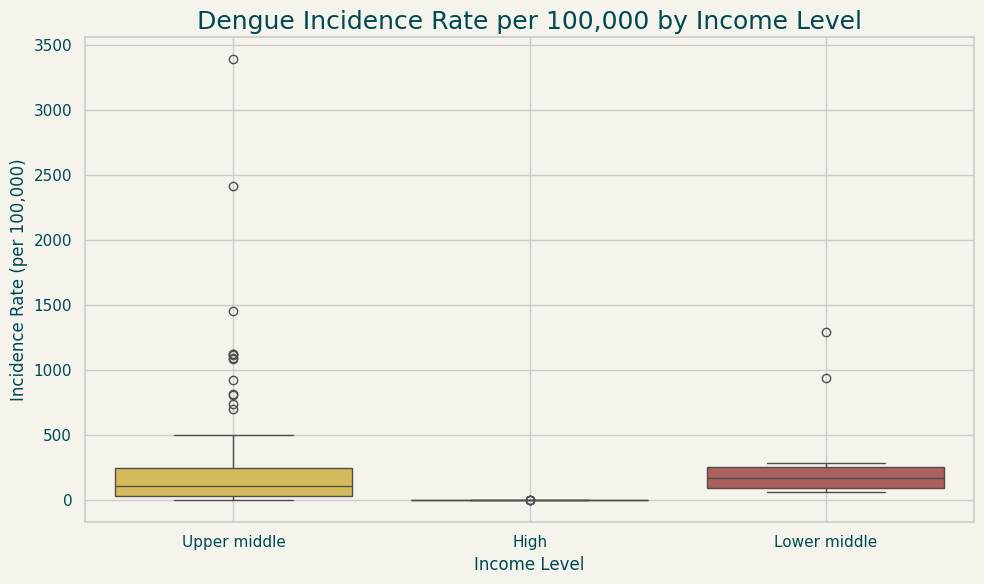

In [ ]:
# Create a boxplot of dengue incidence rate by income level

def box_plot_incidence(df):

    # Color coding
    background_color = '#f4f3ecff'
    box_colors = ['#e8c547ff', '#e8c547ff', '#b85450ff']
    text_color = '#004852ff'

    # Create figure
    plt.figure(figsize=(10, 6))
    plt.gcf().set_facecolor(background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)
    sns.set(style='whitegrid')

    # Create box plot
    sns.boxplot(
        data=df,
        x='Income_Level',
        y='Incidence_Rate',
        palette=box_colors,
        ax=ax
    )

    # Title and axis labels
    plt.title('Dengue Incidence Rate per 100,000 by Income Level', color=text_color, fontsize=18)
    plt.xlabel('Income Level', color=text_color)
    plt.ylabel('Incidence Rate (per 100,000)', color=text_color)
    plt.xticks(color=text_color)
    plt.yticks(color=text_color)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

box_plot_incidence(merged_data_filled)

## Correlation Visuals

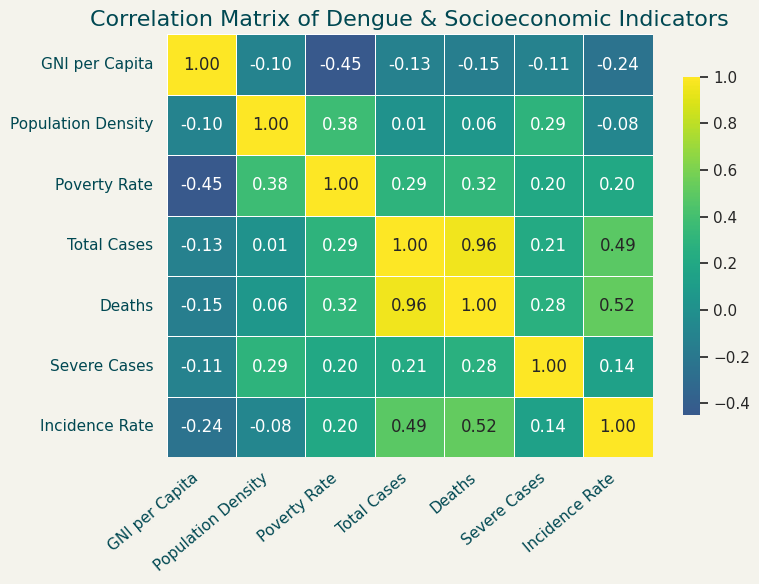

In [ ]:
# Create a correlation matrix heatmap

def corr_heatmap(df):

  # Define new labels for columns/rows
  new_labels = [
        'GNI per Capita',
        'Population Density',
        'Poverty Rate',
        'Total Cases',
        'Deaths',
        'Severe Cases',
        'Incidence Rate'
    ]

  df.index = new_labels
  df.columns = new_labels

  # Color coding
  background_color = '#f4f3ecff'
  text_color = '#004852ff'

  # Create figure
  plt.figure(figsize=(8, 6))
  plt.gcf().set_facecolor(background_color)
  ax = plt.gca()
  ax.set_facecolor(background_color)
  sns.set(style='whitegrid')

  # Heatmap with seaborn
  sns.heatmap(
      df,
      annot=True,
      fmt=".2f",
      cmap='viridis',
      center=0,
      linewidths=0.5,
      cbar_kws={"shrink": 0.8}
  )

  plt.title('Correlation Matrix of Dengue & Socioeconomic Indicators', color=text_color, fontsize=16)
  plt.xticks(rotation=40, ha='right', color=text_color)
  plt.yticks(rotation=0, color=text_color)

  plt.tight_layout()
  plt.show()

corr_heatmap(correlation_matrix)

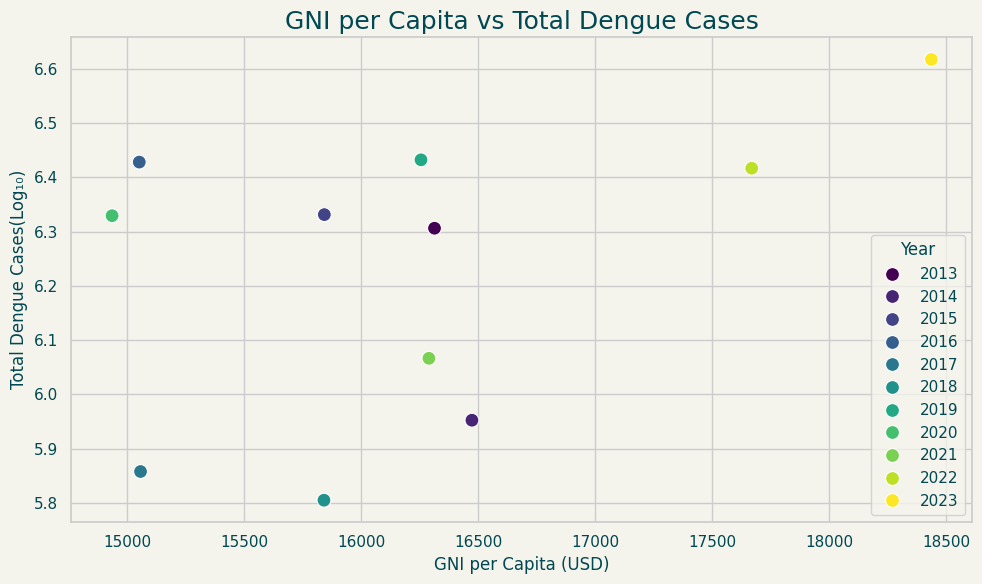

In [ ]:
# Create scatterplot of GNI and total dengue cases

def scatter_GNI_dengue(df):

    # Filter out rows with zero total dengue cases and apply log transformation
    df = df[df['Total Dengue Cases'] > 0].copy()
    df['Log_Total_Dengue_Cases'] = np.log10(df['Total Dengue Cases'])

    # Color coding
    background_color = '#f4f3ecff'
    text_color = '#004852ff'

    # Create figure
    plt.figure(figsize=(10, 6))
    plt.gcf().set_facecolor(background_color)
    ax = plt.gca()
    ax.set_facecolor(background_color)
    sns.set(style='whitegrid')

    # Scatter plot
    sns.scatterplot(
        data=df,
        x='GNI per capita, Atlas method (current US$)',
        y='Log_Total_Dengue_Cases',
        hue='Year',
        palette='viridis',
        s=100,
        legend='full',
        ax=ax
    )

    # Title and axis labels
    plt.title('GNI per Capita vs Total Dengue Cases', color=text_color, fontsize=18)
    plt.xlabel('GNI per Capita (USD)', color=text_color)
    plt.ylabel('Total Dengue Cases(Log₁₀)', color=text_color)
    plt.xticks(color=text_color)
    plt.yticks(color=text_color)

    # Add legend
    legend = plt.legend(title='Year', loc='best', facecolor=background_color)
    for text in legend.get_texts():
        text.set_color(text_color)
    legend.get_title().set_color(text_color)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

scatter_GNI_dengue(yearly_trends)

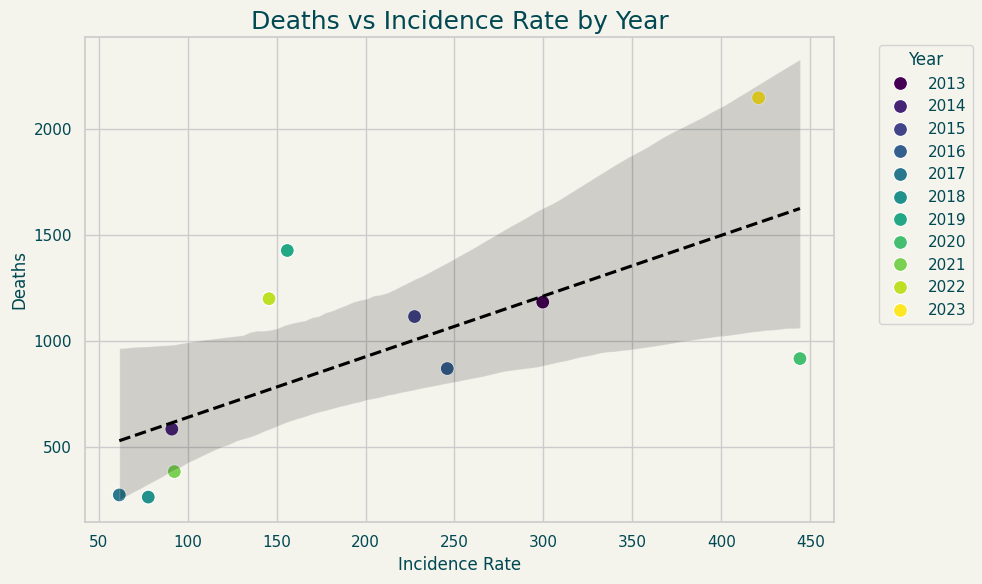

In [ ]:
# Create scatterplot of incidence rate and deaths

def scatter_incidence_dengue(df):

    # Sort by Year
    #df = df.copy().sort_values(by='Year')

    # Color coding
    background_color = '#f4f3ecff'
    text_color = '#004852ff'

    # Create figure
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    plt.gcf().set_facecolor(background_color)
    ax.set_facecolor(background_color)
    sns.set(style='whitegrid')

    # Scatter plot: Deaths vs Incidence Rate by Year
    sns.scatterplot(
        data=df,
        x='Incidence_Rate',
        y='Deaths',
        hue='Year',
        palette='viridis',
        s=100,
        legend='full',
        ax=ax
    )

    # Add regression line
    sns.regplot(
        data=df,
        x='Incidence_Rate',
        y='Deaths',
        scatter=False,
        color='black',
        line_kws={'linestyle': 'dashed', 'label': 'Trend Line'},
        ax=ax
    )

    # Labels and title
    plt.title('Deaths vs Incidence Rate by Year', color=text_color, fontsize=18)
    plt.xlabel('Incidence Rate', color=text_color)
    plt.ylabel('Deaths', color=text_color)
    plt.xticks(color=text_color)
    plt.yticks(color=text_color)
    plt.grid(True)

    # Format legend
    legend = plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor=background_color)
    for text in legend.get_texts():
        text.set_color(text_color)
    legend.get_title().set_color(text_color)

    plt.tight_layout()
    plt.show()

scatter_incidence_dengue(yearly_trends)

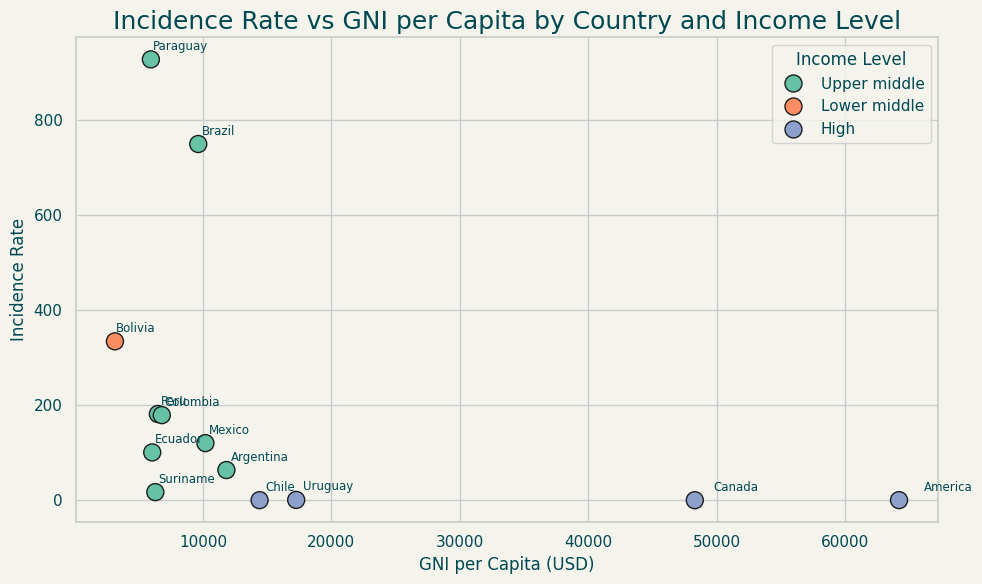

In [ ]:
# Create a bubble chart comparing incidence rate with GNI with income level and country labelling

def bubblechart(df):

    # Prepare data
    df = df.copy().reset_index()
    df['Country'] = df['Country'].replace({'United States of America': 'America'})

    # Color coding
    background_color = '#f4f3ecff'
    text_color = '#004852ff'

    # Create plot
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    plt.gcf().set_facecolor(background_color)
    ax.set_facecolor(background_color)
    sns.set(style='whitegrid')

    # Scatter plot: GNI vs Incidence Rate
    sns.scatterplot(
        data=df,
        x='GNI per capita, Atlas method (current US$)',
        y='Incidence_Rate',
        hue='Income_Level',
        palette='Set2',
        s=150,
        edgecolor='k',
        ax=ax
    )

    # Add country name labels
    for _, row in df.iterrows():
        plt.text(
            row['GNI per capita, Atlas method (current US$)'] * 1.03,  # Slight right shift
            row['Incidence_Rate'] + 20,                                # Slight upward shift
            row['Country'],
            fontsize=8.5,
            color=text_color
        )

    # Labels and title
    plt.xlabel('GNI per Capita (USD)', color=text_color)
    plt.ylabel('Incidence Rate', color=text_color)
    plt.title('Incidence Rate vs GNI per Capita by Country and Income Level', color=text_color, fontsize=18)
    plt.xticks(color=text_color)
    plt.yticks(color=text_color)
    plt.grid(True)

    # Format legend
    legend = plt.legend(title='Income Level', loc='best', facecolor=background_color)
    for text in legend.get_texts():
        text.set_color(text_color)
    legend.get_title().set_color(text_color)

    plt.tight_layout()
    plt.show()

bubblechart(country_performance)

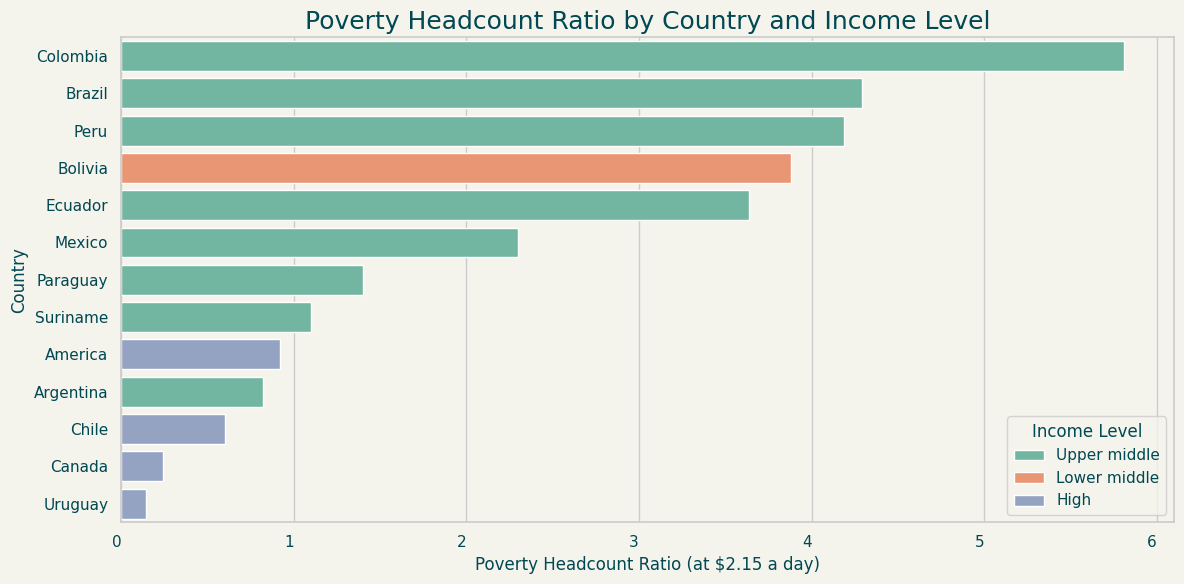

In [ ]:
# Create a grouped bar chart looking at income level and deaths by country

def grouped_bar_deaths(df):

    # Prepare data
    df = df.copy().reset_index()
    df['Country'] = df['Country'].replace({'United States of America': 'America'})

    # Sort by poverty ratio (descending)
    df_sorted = df.sort_values(
        'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
        ascending=False
    )

    # Color coding
    background_color = '#f4f3ecff'
    text_color = '#004852ff'

    # Create plot
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    plt.gcf().set_facecolor(background_color)
    ax.set_facecolor(background_color)
    sns.set(style='whitegrid')

    # Horizontal barplot: Poverty headcount ratio by country
    sns.barplot(
        data=df_sorted,
        x='Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
        y='Country',
        hue='Income_Level',
        palette='Set2',
        ax=ax
    )

    # Labels and title
    ax.set_xlabel('Poverty Headcount Ratio (at $2.15 a day)', color=text_color)
    ax.set_ylabel('Country', color=text_color)
    ax.set_title('Poverty Headcount Ratio by Country and Income Level', color=text_color, fontsize=18)
    plt.xticks(color=text_color, ha='right')
    plt.yticks(color=text_color)

    # Legend formatting
    legend = plt.legend(title='Income Level', loc='best', facecolor=background_color)
    for text in legend.get_texts():
        text.set_color(text_color)
    legend.get_title().set_color(text_color)

    plt.tight_layout()
    plt.show()

grouped_bar_deaths(country_performance)